In [38]:
import pandas as pd
import altair as alt
alt.themes.enable('opaque')

ThemeRegistry.enable('opaque')

## Data prep

In [26]:
# Data import & preview
data = pd.read_csv('property-tax-data.csv')
data.head()

,County,year,residential_taxes,residential_taxes_per_capita
0,Beaverhead,2018,6.476967e+06,688.745913
1,Big Horn,2018,2.505368e+06,187.836846
2,Blaine,2018,2.045030e+06,300.430428
3,Broadwater,2018,3.554921e+06,584.210534
4,Carbon,2018,1.040566e+07,971.220958


The geographic data we're using keeps track of counties using FIPS (Federal Information Processing Standards) codes. That means we need to add fips codes to the underlying data, where individual counties are identified only by name

In [16]:
fips_table = pd.read_csv('mt-county-ids.csv')
fips_table.head()

,County,County #,fips
0,Beaverhead,18,30001
1,Big Horn,22,30003
2,Blaine,24,30005
3,Broadwater,43,30007
4,Carbon,10,30009


In [27]:
# Joining the tables with Pandas merge command
# For more info, see https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html

data_merged = fips_table.merge(data, left_on='County', right_on='County', indicator=True)
data_merged.head()

# left_on and right_on tell the command which columns should match each other
# The "left"/first table is fips_table, "right" is our un-fipped data
# indicator=True gives us the _merge column in the output we can use to check the results

# Note that merge is case sensitive
# Note that "Lewis & Clark" county uses an ampersand instead of an "and" here

,County,County #,fips,year,residential_taxes,residential_taxes_per_capita,_merge
0,Beaverhead,18,30001,2018,6.476967e+06,688.745913,both
1,Big Horn,22,30003,2018,2.505368e+06,187.836846,both
2,Blaine,24,30005,2018,2.045030e+06,300.430428,both
3,Broadwater,43,30007,2018,3.554921e+06,584.210534,both
4,Carbon,10,30009,2018,1.040566e+07,971.220958,both


In [29]:
# Checking merge outcomes
data_merged['_merge'].value_counts()
# Goal here is to see a 56 counties in "both", indicating rows are populated by both the right and left tables
# values in right_only or left_only indicate a merge error of some sort (e.g. mismatched county names)
# run `data_merged[data_merged['_merge'] != 'both']` to see rows with merge errors for troubleshooting

both          56
right_only     0
left_only      0
Name: _merge, dtype: int64

## Mapping

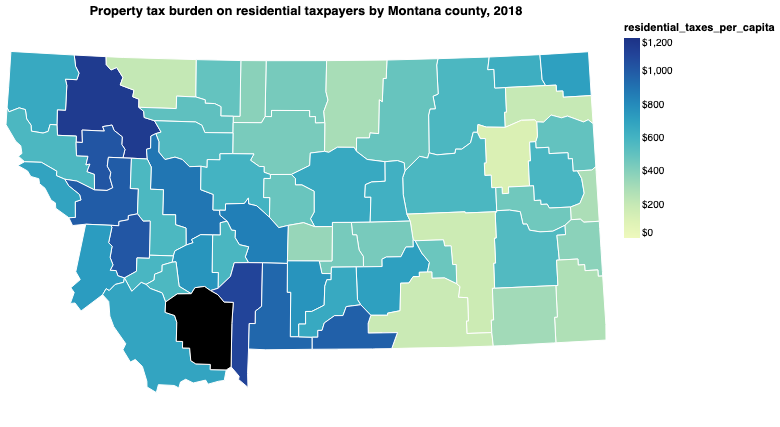

In [47]:
# Adapted from: https://altair-viz.github.io/gallery/choropleth.html
# This pulls county spatial data from an open source repository on Github
# Won't work without an internet connection
# Data is formatted as a TopoJSON file, see https://github.com/topojson/topojson
mt_counties_topojson_url = 'https://gist.githubusercontent.com/eidietrich/30118ba41ea41681948b06b0cf75864f/raw/9f8a2ed6d61d8ad7c42207ab4ef55a1e6548a909/mt-10m-counties.json'
county_lines = alt.topo_feature(mt_counties_topojson_url, 'counties')

# set plot data
plot_data = data_merged

# set color scheme
# Options at https://vega.github.io/vega/docs/schemes/
color_scheme = 'yellowgreenblue'

# Set color scale output range
lower_bound = 0
upper_bound = 1200



background = alt.Chart(county_lines).mark_geoshape(
    stroke='white' # Draw a white line around each county shape
).encode(
    color=alt.Color(
        'residential_taxes_per_capita:Q', # field to plot with color
        scale=alt.Scale(
            domain=[lower_bound,upper_bound], # set color scale input range
            scheme=color_scheme, # set custom color scheme
        ),
        legend=alt.Legend(format='$,.0f') # Formats numbers on color scale legend
    ),
    tooltip=['County:N','residential_taxes_per_capita:Q'] # fields to show in tooltip
).transform_lookup(
    # This is section that merges plot data with spatial county boundary data
    lookup='id', # Data field in (FIPS id code)
    from_=alt.LookupData(
        plot_data, # data to merge in
        'fips', # id code field in plot data
        ['County','residential_taxes_per_capita'] # fields to make available for plotting 
    )
).project(
    type='albers', # Sets map projection
    rotate=[110,0] # Keeps Montana from being rotated awkwardly
).properties(
    # Set output properties
    width=600,
    height=400,
    title='Property tax burden on residential taxpayers by Montana county, 2018'
)

(background).configure_view(
    strokeOpacity=0 # eliminates gray box around map
)